In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns


filename = "./capture_data/clean_data.csv"
df = pd.read_csv(filename)

In [11]:
# Show first few rows
print("Data preview:")
print(df.head())

import seaborn as sns
metrics = [
"temperature_f",
"moisture_pct",
"ec_us_cm",
"ph",
"n_mg_kg",
"p_mg_kg",
"k_mg_kg"
]

Data preview:
                    timestamp  camera_id  \
0  1970-01-01T06:31:11.739203          0   
1  1970-01-01T06:31:22.772735          0   
2  1970-01-01T06:31:44.327990          0   
3  1970-01-01T06:31:54.540762          0   
4  1970-01-01T06:32:25.187522          0   

                                  image_path   latitude  longitude  \
0  capture_data/cam0_1970-01-01_06-31-11.jpg  12.970372  79.156086   
1  capture_data/cam0_1970-01-01_06-31-22.jpg  12.970372  79.156084   
2  capture_data/cam0_1970-01-01_06-31-44.jpg  12.970372  79.156084   
3  capture_data/cam0_1970-01-01_06-31-54.jpg  12.970373  79.156082   
4  capture_data/cam0_1970-01-01_06-32-25.jpg  12.970361  79.156098   

   temperature_f  moisture_pct  ec_us_cm     ph  n_mg_kg  p_mg_kg  k_mg_kg  
0           31.4           6.7     337.0   9.59    220.0    300.0    760.0  
1           30.1           6.7     338.0   7.67    220.0    300.0    770.0  
2           28.9           8.5     106.0  10.00    110.0    140.0    

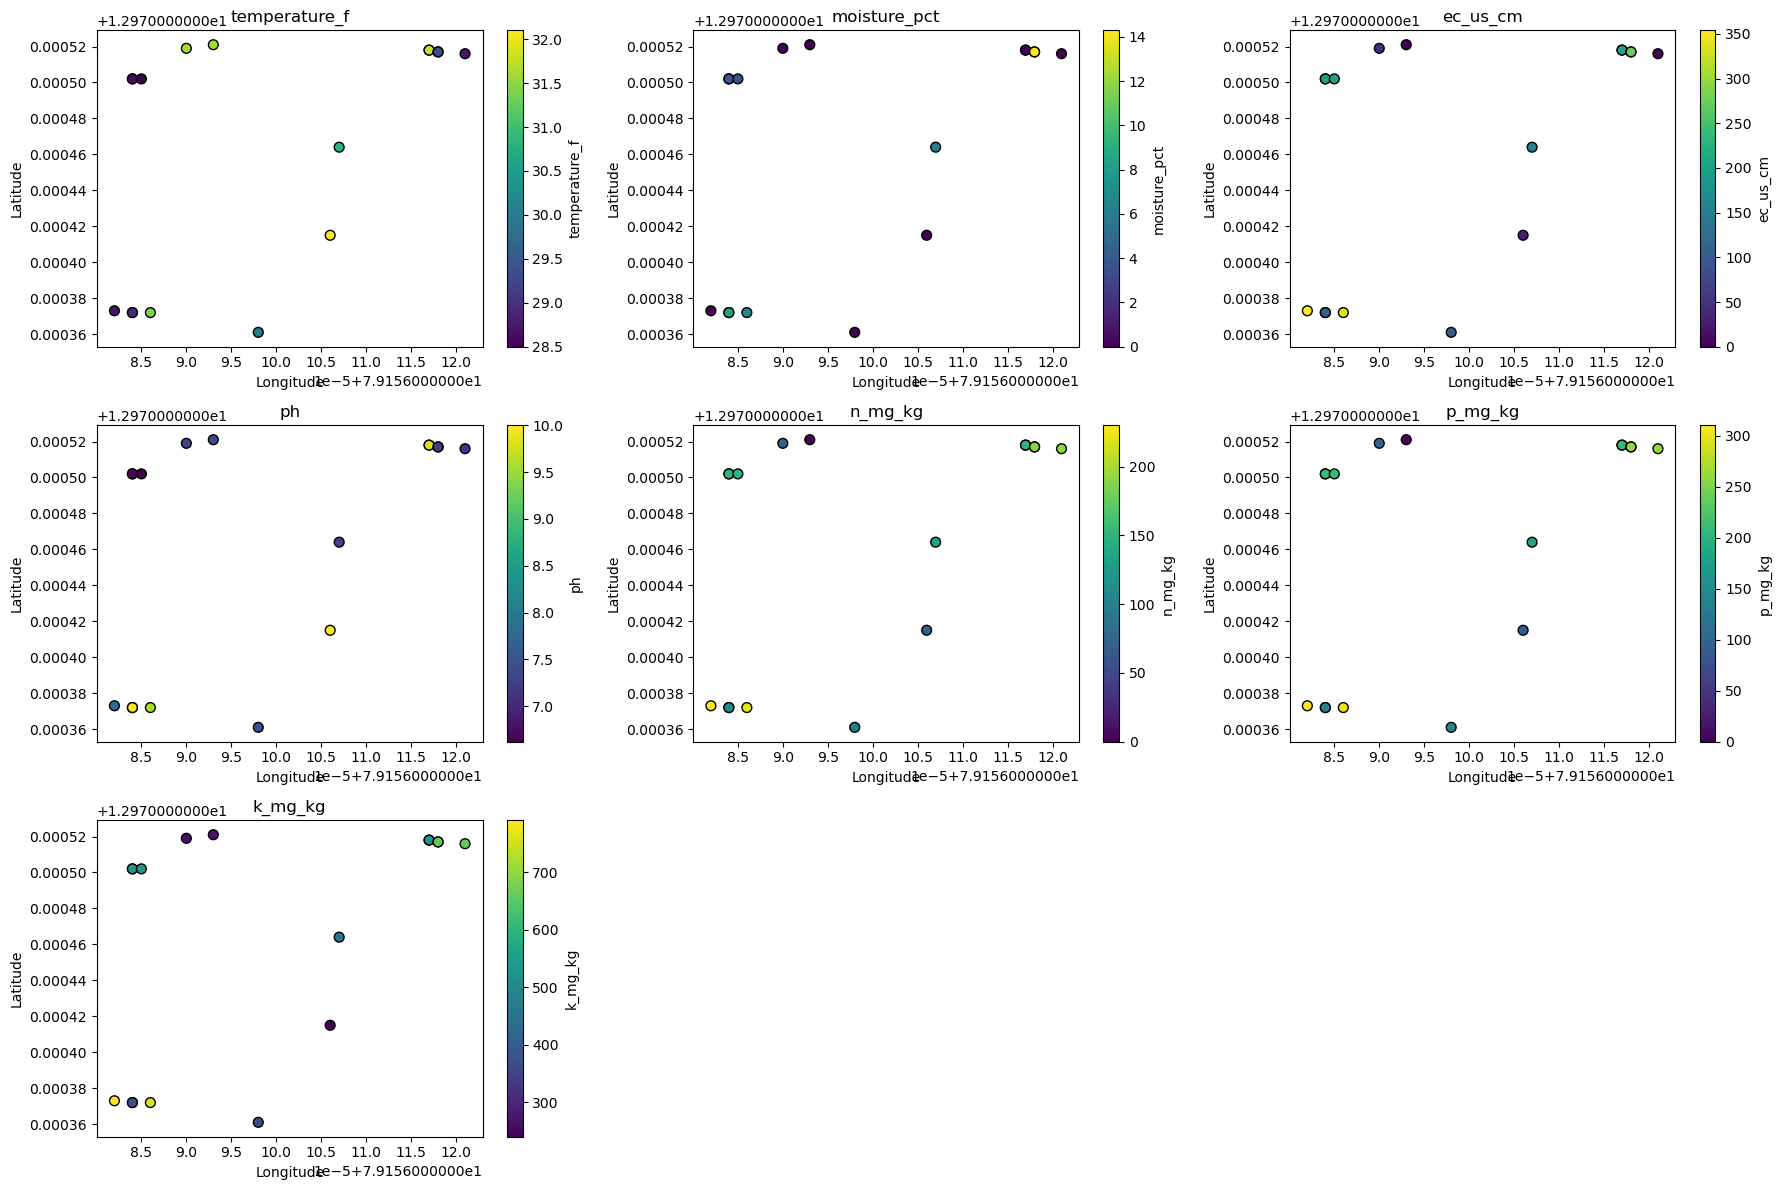

In [12]:
# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sc = axes[i].scatter(
        df["longitude"], df["latitude"],
        c=df[metric], cmap="viridis", s=50, edgecolor="k"
    )
    axes[i].set_title(metric)
    axes[i].set_xlabel("Longitude")
    axes[i].set_ylabel("Latitude")
    plt.colorbar(sc, ax=axes[i], label=metric)

# Hide unused subplot if metrics < 9
for j in range(len(metrics), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

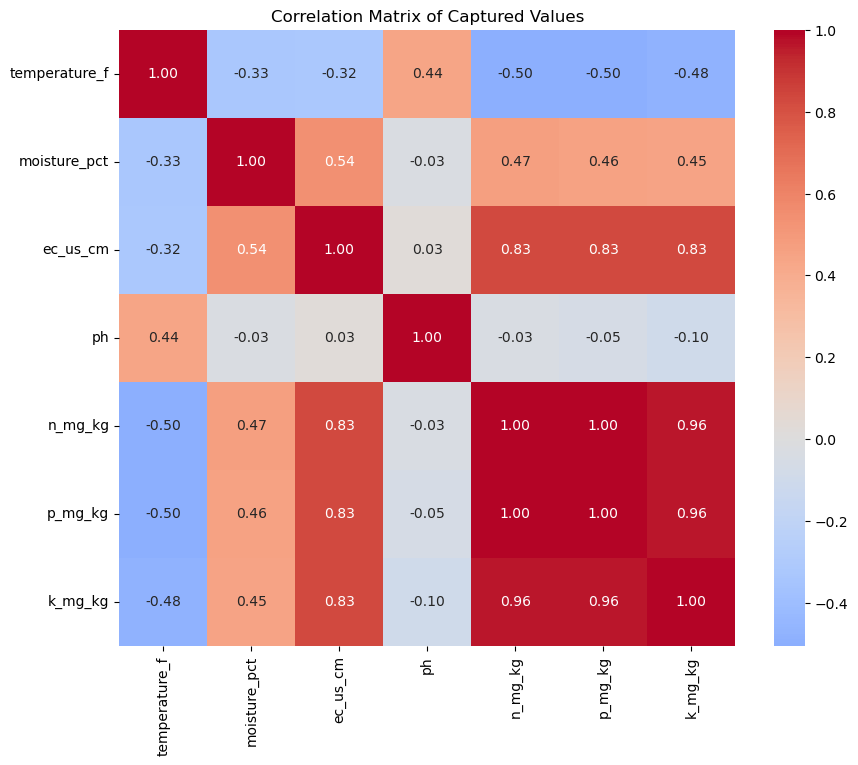

In [13]:
# Compute correlation matrix
corr = df[metrics].corr(method="pearson")   # you can also try "spearman" or "kendall"

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f", square=True)
plt.title("Correlation Matrix of Captured Values")
plt.show()

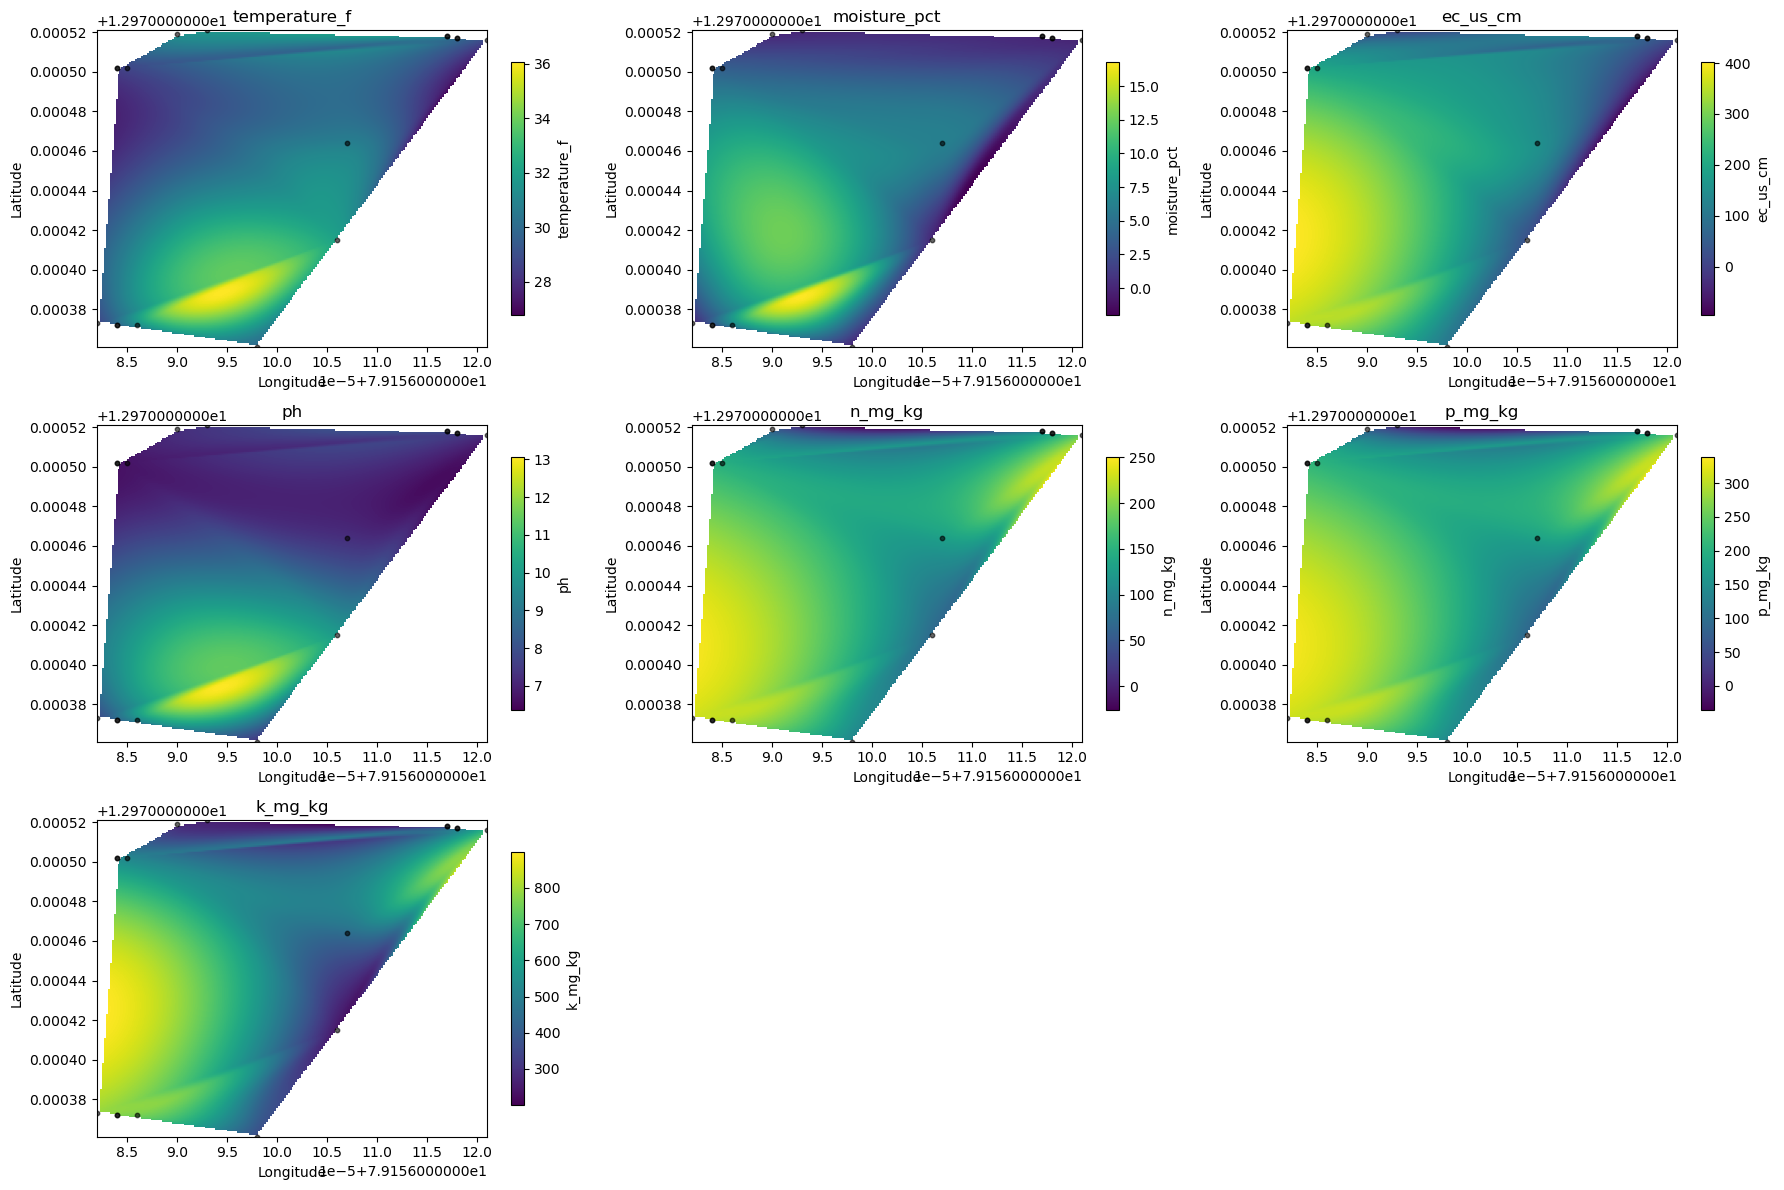

In [14]:
df_clean = df.dropna(subset=["latitude", "longitude"] + metrics)

lat = df_clean["latitude"].values
lon = df_clean["longitude"].values

# Define voxel grid resolution (increase 200j for smoother maps)
grid_x, grid_y = np.mgrid[
    lon.min():lon.max():200j,
    lat.min():lat.max():200j
]

# Subplots
n = len(metrics)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    values = df_clean[metric].values

    # Interpolate to grid (try cubic, fallback to linear if not enough points)
    try:
        grid_z = griddata((lon, lat), values, (grid_x, grid_y), method="cubic")
    except Exception:
        grid_z = griddata((lon, lat), values, (grid_x, grid_y), method="linear")

    # Plot heatmap
    im = axes[i].imshow(
        grid_z.T, extent=(lon.min(), lon.max(), lat.min(), lat.max()),
        origin="lower", cmap="viridis", aspect="auto"
    )
    fig.colorbar(im, ax=axes[i], label=metric, shrink=0.8)
    axes[i].scatter(lon, lat, c="k", s=10, alpha=0.6)
    axes[i].set_title(metric)
    axes[i].set_xlabel("Longitude")
    axes[i].set_ylabel("Latitude")

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()